### clustering experimental notebook
contributors: bpben, shreyapandit, j-t-t

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sys
sys.path.append("../src/")
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
from sklearn.metrics import silhouette_score

In [3]:
def pca_results(good_data, pca):
# adapted from: https://github.com/viktortnk/udacity-ml/blob/master/projects/creating_customer_segments/renders.py
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (16,10))

	# Plot the feature weights as a function of the components
	colors = ['r','g','b','y','m','k','c']*2
	components.plot(ax = ax, kind = 'bar', color=colors)
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

In [4]:
city_columns = {'boston':['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 
                          'Surface_Tp', 'F_F_Class', 'visionzero', 
                          'Conflict', 'intersection', 'jam_percent'],
               'cambridge':['lanes', 'hwy_type', 'osm_speed', 'oneway',
                           'signal', 'seeclickfix', 'width',
                           'jam', 'jam_percent'],
                'dc':['lanes', 'hwy_type', 'osm_speed', 'oneway',
                           'signal']}



# Loading dataframe used in modeling 

In [5]:
city = 'boston'

In [6]:
df = pd.read_csv('../data/{}/processed/seg_with_predicted.csv'.format(city),
                dtype={'segment_id':'str'})

### Selecting a subset of columns which we will use in further analysis

In [7]:
df_minimal_columns = df[city_columns[city]].fillna(0)

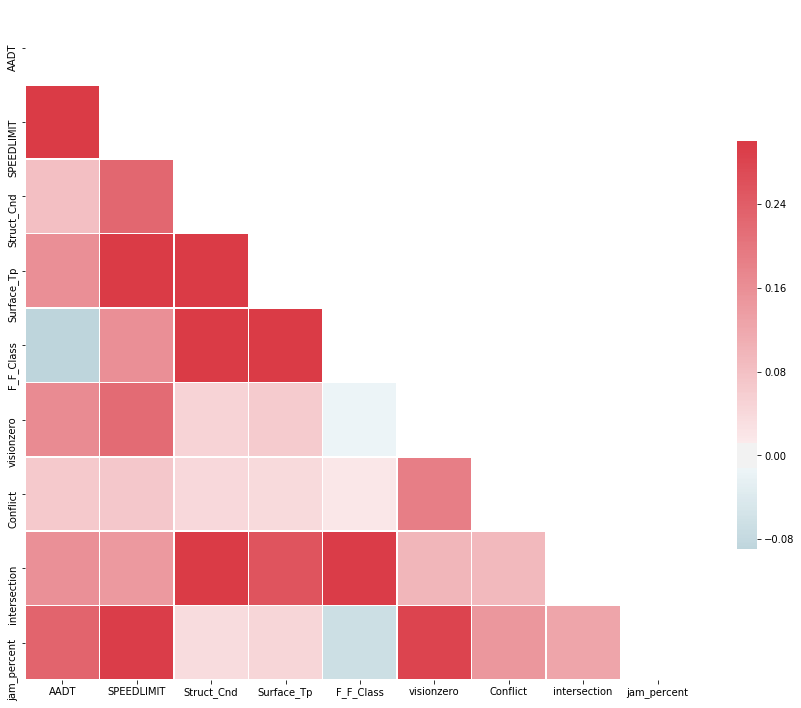

In [8]:
corr = df_minimal_columns.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Apply PCA

In [9]:
from sklearn.metrics.pairwise import cosine_distances

In [10]:
class Clusterer(object):
    
    def __init__(self, X):
        self.X = X
        
    def reduce_dimension(self, method, scale=True):
        if scale:
            X = StandardScaler().fit_transform(self.X)
        else:
            X = self.X
        self.reduce_X = method.fit_transform(X)
    
    def get_dists(self, features=None):
        if features is None:
            features = self.reduce_X
        self.dists = cosine_distances(features)
        
    def cluster(self, method, features=None):
        if features is None:
            features = self.reduce_X
        self.clusterer = method
        self.clusters = self.clusterer.fit_predict(features)
        

In [11]:
test_dummies = pd.DataFrame()
for c in df_minimal_columns:
    d = pd.get_dummies(df_minimal_columns[c])
    d.columns = [c+'_'+str(col) for col in d.columns]
    test_dummies = pd.concat([test_dummies, d], axis=1)

In [12]:
df_input = df_minimal_columns.fillna(0)
#df_input = test_dummies.fillna(0)
pca = PCA(n_components=4)#,random_state=12345)
# make pipeline
pipe = make_pipeline(StandardScaler(), pca)
pipe.fit(df_input)
pca_result = pipe.fit_transform(df_input)


/Users/B/anaconda/envs/crash-model/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/B/anaconda/envs/crash-model/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/B/anaconda/envs/crash-model/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/B/anaconda/envs/crash-model/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Explained Variance,AADT,SPEEDLIMIT,Struct_Cnd,Surface_Tp,F_F_Class,visionzero,Conflict,intersection,jam_percent
Dimension 1,0.3047,0.1925,0.3139,0.4980,0.5159,0.4578,0.1368,0.0909,0.3081,0.1369
Dimension 2,0.1988,0.4515,0.3790,-0.2190,-0.1828,-0.3442,0.4092,0.2350,0.0399,0.4780
Dimension 3,0.1176,-0.4459,-0.3625,0.0225,-0.0580,0.0924,0.3478,0.7065,0.1622,0.1047
Dimension 4,0.0926,-0.1951,0.1587,0.1019,0.1966,0.1107,0.3502,-0.0234,-0.8662,0.0439


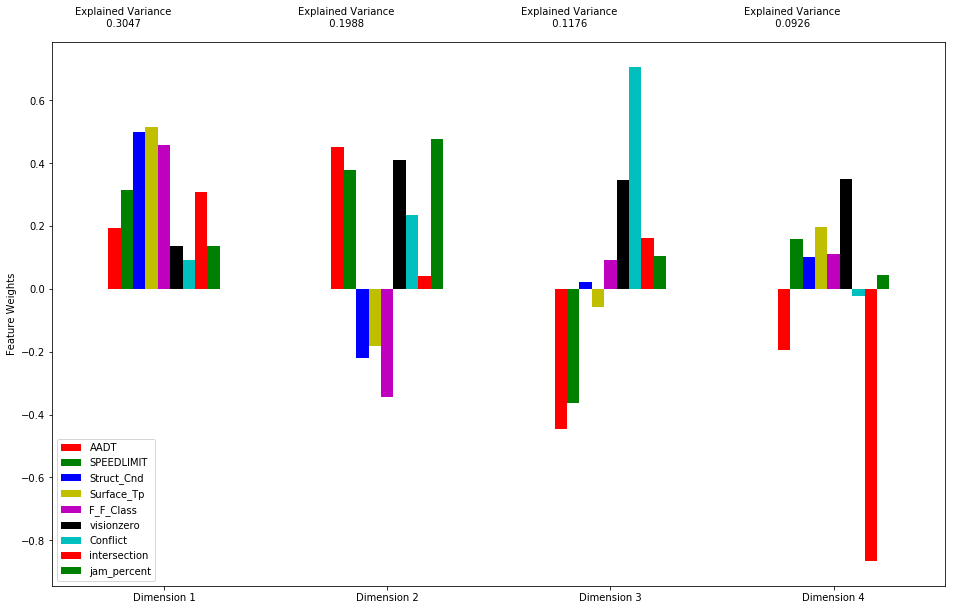

In [13]:
pca_results(df_input, pipe.named_steps.pca)

### High risk (red) and Non high risk segments plotted
High risk = Prediction above a threshold.  Here I use 75 to more clearly indicate highest risk

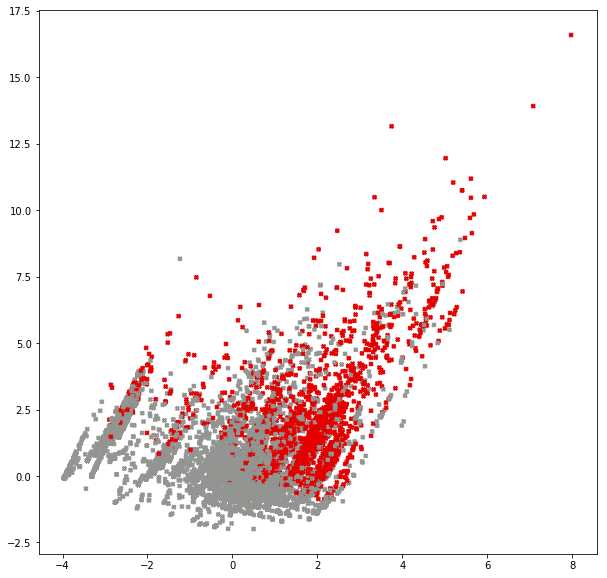

In [14]:
plt.figure(figsize=[10,10])
color_mapping = {False: sns.xkcd_rgb['grey'], True: sns.xkcd_rgb['red']}
colors = list(map(lambda x: color_mapping[x], df.prediction>.75))
plt.scatter(
        pca_result[:,0],
        pca_result[:,1],
        s=16,
        marker="X", c = colors)

# Applying KMeans Clustering and trying to list out characteristics of each cluster

In [15]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
        if k>1:
            print(silhouette_score(X, kmeans.labels_))

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

0.5063785120503189
0.5323804136307554
0.5008024700180125
0.5097003541664535


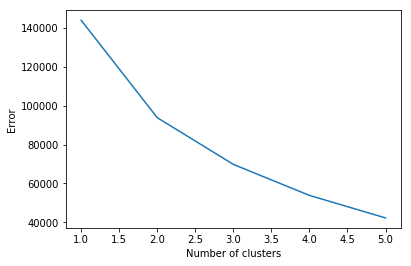

In [16]:
evaluate_clusters(pca_result,5)
plt.show()

In [17]:
from sklearn.cluster import KMeans

#INTEGER FOR RANDOM SEEDING 
random_state = 170

n_clusters = 3

y_pred = KMeans(n_clusters=n_clusters, init='k-means++',random_state=random_state).fit_predict(df_minimal_columns)
cluster_labels = y_pred

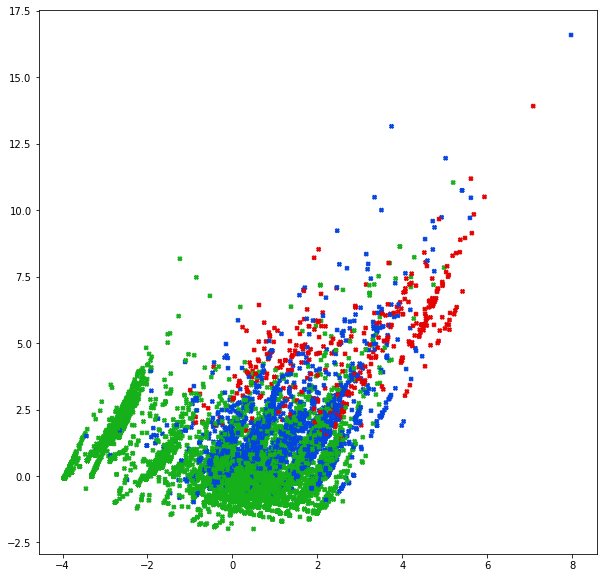

In [18]:
plt.figure(figsize=[10,10])
#vis_x_filtered = vis_x[]
color_mapping = {0: sns.xkcd_rgb['green'], 1: sns.xkcd_rgb['red'], 2: sns.xkcd_rgb['blue'], 
                 3: sns.xkcd_rgb['yellow'], 4: sns.xkcd_rgb['grey']}
colors = list(map(lambda x: color_mapping[x], cluster_labels))
plt.scatter(
        pca_result[:,0],
        pca_result[:,1],
        s=16,
        marker="X",
        c = colors
        )

In [19]:
df_minimal_columns['cluster_label'] =  cluster_labels

## Find key characteristics of these clusters
- top features which are different in the given cluster when compared with the rest of the clusters
- select those specific features to explain the characteristics of the clusters

In [38]:
from sklearn.feature_selection import SelectPercentile,f_classif
from sklearn.model_selection import train_test_split


def get_top_features_from_dataset(data, cluster_labels,n_clusters=3):

    temp_labels = []
    dataset = data.values
    labels = set(cluster_labels)
    for label in labels:
        revised_labels = pd.Series(cluster_labels)        
        revised_labels = revised_labels.apply(lambda x: 1 if x == label else 0)
        
        X_train, X_test, y_train, y_test = train_test_split(dataset, revised_labels.values,
                                                            random_state=0,test_size=1)
        fscore = f_classif(X_train,y_train)

        top_feature_set = {
            "cluster_label": str(label),
            "names" : list(data.columns.values),
            "scores" : fscore[0].tolist(),
            "pvalues" : fscore[1].tolist()               
        }    
    
        temp_labels.append(top_feature_set)

    return temp_labels

In [39]:
# make descriptives df
desc_df = df_minimal_columns.copy(deep=True)
desc_df['crash_pct'] = df['target']
desc_df['prediction'] = df['prediction']
profile_desc_df = desc_df.groupby('cluster_label').mean()
# normalize by average
profile_desc_df = profile_desc_df.T.apply(lambda c: c/desc_df.mean()).T
profile_desc_df.drop(['cluster_label'], axis=1, inplace=True)

In [40]:
# plot bars for different clusters
def plot_levels(data, levels, by=df_minimal_columns['cluster_label']):
    lv_data = data[levels]
    p = lv_data.groupby(by).mean().T.plot(kind='bar')
    return(p)

Text(0, 0.5, 'proportion of segments')

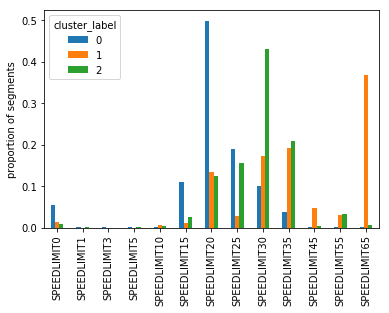

In [41]:
p = plot_levels(df, df.filter(regex='SPEEDLIMIT').iloc[:,1:].columns)
p.set_ylabel('proportion of segments')

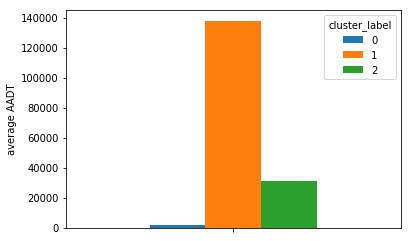

In [42]:
p = plot_levels(df, ['AADT'])
p.set_ylabel('average AADT')
p.set_xticklabels([]);

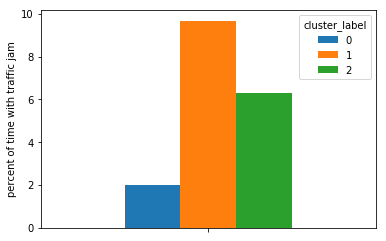

In [43]:
p = plot_levels(df, ['jam_percent'])
p.set_ylabel('percent of time with traffic jam')
p.set_xticklabels([]);

In [44]:
# get the factors of the different columns
col_w_factors = []
for x in df_minimal_columns.columns:
    sub_cols = df.filter(regex=x).columns.tolist()
    if len(sub_cols)>2:
        sub_cols = sub_cols[1:]
    else:
        sub_cols = [sub_cols[0]]
    col_w_factors.extend(sub_cols)

IndexError: list index out of range

In [45]:
data = df[col_w_factors]
for result in get_top_features_from_dataset(data, cluster_labels,n_clusters):
    #Get top values of pvalues
    top_5_p_values_indices = np.argsort(result['pvalues'])[0:10]
    cluster_df = data[df_minimal_columns['cluster_label'] == int(result['cluster_label'])]
    
    print("\n\nCluster : %s"%str(result['cluster_label']))
    print("-------")
    print("Mean crashes: %1.5f" % df.target.loc[cluster_df.index].mean())
    print("Characteristics of cluster %s"%str(result['cluster_label']))
    
    tmp_df = pd.DataFrame(columns=['feature_name','mean in cluster','mean (overall)','proportion ratio'])
    
    for index in range(len(data.columns)):
        name = result['names'][index]
        tmp_df= tmp_df.append({
            'feature_name': name  ,
            'mean in cluster': cluster_df[name].mean() ,
            'mean (overall)': data[name].mean(),
            'proportion ratio': cluster_df[name].mean() / data[name].mean()
        },ignore_index=True)

        
    print(tmp_df.to_string(index=False))
    



Cluster : 0
-------
Mean crashes: 0.19553
Characteristics of cluster 0
feature_name  mean in cluster  mean (overall)  proportion ratio
        AADT      1546.714615     6553.153922          0.236026
 SPEEDLIMIT0         0.054643        0.049717          1.099082
 SPEEDLIMIT1         0.001302        0.001204          1.081657
 SPEEDLIMIT3         0.000501        0.000446          1.123260
 SPEEDLIMIT5         0.001753        0.001650          1.062543
SPEEDLIMIT10         0.001252        0.001650          0.758959
SPEEDLIMIT15         0.109035        0.099612          1.094600
SPEEDLIMIT20         0.498748        0.457886          1.089241
SPEEDLIMIT25         0.189372        0.183618          1.031337
SPEEDLIMIT30         0.100821        0.132786          0.759275
SPEEDLIMIT35         0.037914        0.056271          0.673778
SPEEDLIMIT45         0.001052        0.001962          0.536101
SPEEDLIMIT55         0.002354        0.005574          0.422346
SPEEDLIMIT65         0.001252  